In [145]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology as skmorph
import time
import cv2 
%matplotlib inline

VERBOSE = False
np.random.seed(42)

def load(path):
    ims = []
    for fname in sorted(glob.glob(path)):
        im = Image.open(fname)
        ims.append(np.array(im))
    return np.array(ims)

def load_bmp(path): 
    ims = load(path)[0]/255
    return (ims[:,:,0] + ims[:,:,1] + ims[:,:,2])/3


In [146]:
helper = load_bmp("../input/bsc-real/bsc_real/helper.bmp")
labels = load_bmp("../input/bsc-real/bsc_real/labels.bmp")
labels[labels != 1] = 0
labels = 1 - labels

snips = load("../input/bsc-real/bsc_real/*.tiff")
snips = snips/np.iinfo(np.uint16).max
snips_original = snips.copy()

snips = np.array([(im - im.mean()) / im.std() for im in snips]) #per-image standardization
bounds = (-3.25, np.max(snips))
snips = (snips-bounds[0]) /(bounds[1]-bounds[0])
snips = np.clip(snips, 0, 1)

#system of equations for image registration with labels 
a = np.array([[570, 1, 0, 0, 0, 0, 0, 0, 0], [736, 0, 1, 0, 0, 0, 0, 0, 0],
              [688, 1, 0, 0, 0, 0, 0, 0, 0], [905, 0, 1, 0 ,0, 0, 0, 0, 0],
              [526, 1, 0, 0, 0, 0, 0, 0, 0], [77, 0, 1, 0, 0, 0, 0, 0, 0],
              [586, 1, 0, 0, 0, 0, 0, 0, 0], [591, 0, 1, 0, 0, 0, 0, 0, 0],
              
             [614, 0, 0, 1, 0, 0, 0, 0, 0], [58, 0, 0, 0, 1, 0, 0, 0, 0],
             [274, 0, 0, 1, 0, 0, 0, 0, 0], [321, 0, 0, 0, 1, 0, 0, 0, 0],
             [628, 0, 0, 1, 0, 0, 0, 0, 0], [406, 0, 0, 0, 1, 0, 0, 0, 0],
             [647, 0, 0, 1, 0, 0, 0, 0, 0], [838, 0, 0, 0, 1, 0, 0, 0, 0],
            
             [581, 0, 0, 0, 0, 1, 0, 0, 0], [28, 0, 0, 0, 0, 0, 1, 0, 0],
             [748, 0, 0, 0, 0, 1, 0, 0, 0], [74, 0, 0, 0, 0, 0, 1, 0, 0],
             [625, 0, 0, 0, 0, 1, 0, 0, 0], [357, 0, 0, 0, 0, 0, 1, 0, 0],
             [607, 0, 0, 0, 0, 1, 0, 0, 0], [699, 0, 0, 0, 0, 0, 1, 0, 0],
             [267, 0, 0, 0, 0, 1, 0, 0, 0], [961, 0, 0, 0, 0, 0, 1, 0, 0],
            
             [573, 0, 0, 0, 0, 0, 0, 1, 0], [135, 0, 0, 0, 0, 0, 0, 0, 1],
             [585, 0, 0, 0, 0, 0, 0, 1, 0], [330, 0, 0, 0, 0, 0, 0, 0, 1],
             [754, 0, 0, 0, 0, 0, 0, 1, 0], [766, 0, 0, 0, 0, 0, 0, 0, 1],
             [454, 0, 0, 0, 0, 0, 0, 1, 0], [995, 0, 0, 0, 0, 0, 0, 0, 1]
            ])

b = np.array([1930, 6816, 2184, 7183, 1833, 5396, 1967, 6501,
              2044, 3964, 1309, 4532, 2075, 4709, 2114, 5647,
              1984, 2519, 2347, 2624, 2082, 3220, 2044, 3964, 1310, 4532,
              1981, 1360, 2008, 1778, 2375, 2719, 1725, 3218
              ])

X, _, _, _ = np.linalg.lstsq(a, b)
tx = (X[1::2] / X[0] + 0.5).astype(np.int)
ty = (X[2::2] / X[0] + 0.5).astype(np.int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [147]:
# registration 
scale_factor = X[0]**(-1)
scaled_helper = cv2.resize(helper, dsize=(0,0), fx=scale_factor, fy=scale_factor)
scaled_labels = cv2.resize(labels, dsize=(0,0), fx=scale_factor, fy=scale_factor)


#x-interval 
x_offset = 254 
x_offset2 = 258 

data = []
data_y = []
guideline = []
for idx, snip in enumerate(snips): 
    tmp_guideline = scaled_helper[ty[idx]:ty[idx]+1024, tx[idx]:tx[idx]+1024]
    tmp_label = scaled_labels[ty[idx]:ty[idx]+1024, tx[idx]:tx[idx]+1024]
    data.append(snip[:512, x_offset:-x_offset2])
    data.append(snip[512:, x_offset:-x_offset2])
    data_y.append(tmp_label[:512, x_offset:-x_offset2])
    data_y.append(tmp_label[512:, x_offset:-x_offset2])
    guideline.append(tmp_guideline[:512, x_offset:-x_offset2])
    guideline.append(tmp_guideline[512:, x_offset:-x_offset2])

data = np.array(data)
data_y = np.array(data_y)
guideline = np.array(guideline)

# initial split 
data_test = data[-3:]
labels_test = data_y[-3:]
data = data[:-3]
data_y = data_y[:-3]

In [148]:
from skimage import feature
from skimage import measure

# preprocessing before particle cutouts:
# particle masks and their region properties 
def cutout_pre(data, min_size = 25000, threshold=0.7): #20000
    thr = data < threshold
    cann = np.array([feature.canny(im, sigma=0.5, low_threshold=0.1, high_threshold=0.7) for im in data])
    cann = np.array([skmorph.binary_dilation(im, selem=skmorph.selem.disk(1)) for im in cann])
    border_arr = np.ones_like(cann)
    border_arr[:, 1:-1, 1:-1] = 0
    cann[border_arr == 1] = 1
    res = (1 - cann) * thr
    labels = np.array([skmorph.label(img, connectivity=1) for img in res.astype(np.uint8)])
    props = [measure.regionprops(im) for im in labels]
    clean = np.array([skmorph.remove_small_objects(im, min_size=min_size, connectivity=1) for im in labels])
    clean = np.array([skmorph.label(img, connectivity=1) for img in clean.astype(np.uint8)])
    props = [measure.regionprops(im) for im in clean]
    return clean, props


In [149]:
RES = (256,256)

# make cutouts 
def cutout(data, data_y, clean, props): 
    tmp_data = []
    tmp_labels = []
    tmp_masks = []

    for i, img in enumerate(clean):
        for j in range(0, np.max(img)): 
            msk = img == j + 1
            masked_data = data[i]# * msk
            masked_labels = msk * data_y[i]
            bbox = props[i][j].bbox 
            diff = int(((bbox[2] - bbox[0]) - (bbox[3]-bbox[1]))/ 2 + 0.5)
            if VERBOSE: print("info for cutout scaling:")
            
            #find coordinates for square bounding box
            if diff > 0: 
                l = np.maximum(0, bbox[1]-diff - np.minimum(0, 512-(bbox[3]+diff)))
                h = np.minimum(512, bbox[3]+diff + np.minimum(0, bbox[1]-diff))
                res_img = cv2.resize(masked_data[bbox[0]:bbox[2], l:h], dsize=RES, interpolation=cv2.INTER_LINEAR)
                if VERBOSE: print(j,": ", bbox[2]-bbox[0], (h-l))
                res_y = cv2.resize(masked_labels[bbox[0]:bbox[2], l:h], dsize=RES, interpolation=cv2.INTER_LINEAR)
                res_msk = cv2.resize(msk.astype(np.float32)[bbox[0]:bbox[2], l:h], dsize=RES, interpolation=cv2.INTER_LINEAR)
            else: 
                l = np.maximum(0, bbox[0]+diff - np.minimum(0, 512-(bbox[2]-diff)))
                h = np.minimum(512, bbox[2]-diff + np.minimum(0, bbox[0]+diff))
                res_img = cv2.resize(masked_data[l:h, bbox[1]:bbox[3]], dsize=RES, interpolation=cv2.INTER_LINEAR)
                if VERBOSE: print(j,": ", (l, h), bbox[1], bbox[3])
                res_y = cv2.resize(masked_labels[l:h, bbox[1]:bbox[3]], dsize=RES, interpolation=cv2.INTER_LINEAR)
                res_msk = cv2.resize(msk.astype(np.float32)[l:h, bbox[1]:bbox[3]], dsize=RES, interpolation=cv2.INTER_LINEAR)

            tmp_data.append(res_img) 
            tmp_labels.append(res_y)
            tmp_masks.append(res_msk)

    tmp_data = np.array(tmp_data)
    tmp_labels=np.array(tmp_labels)
    tmp_masks =np.array(tmp_masks)
    tmp_labels = np.array([skmorph.remove_small_objects(im, min_size=9, connectivity=2) 
                            for im in (measure.label(np.round(tmp_labels))).astype(np.int)])
    tmp_labels[tmp_labels != 0] = 1
    return tmp_data, tmp_labels, tmp_masks

clean, props = cutout_pre(data)
tmp_data, tmp_labels, tmp_masks = cutout(data, data_y, clean, props)

shape: (7, 256, 256) 
data: [0.         0.04449627 0.04489042 ... 0.97247426 0.97268079 0.97290635] 
labels: [0 1]


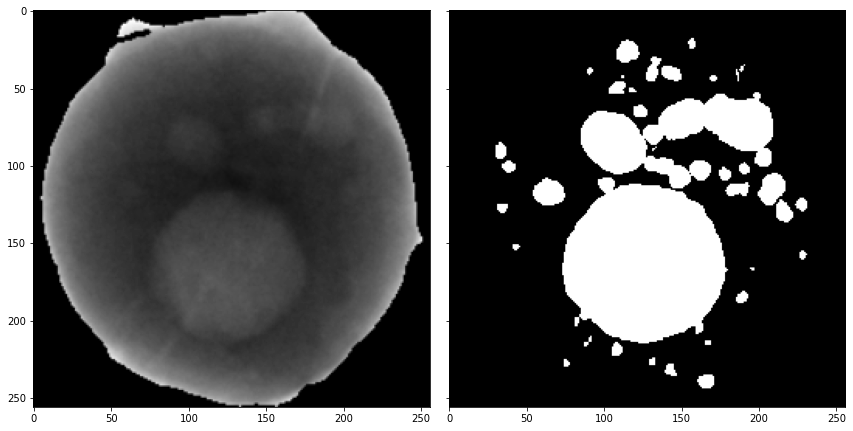

In [150]:
idx = 1
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12,6), sharex=True, sharey=True)
axs[0].imshow(tmp_masks[idx]*tmp_data[idx], cmap="gray")
axs[1].imshow(np.round(tmp_labels[idx]), cmap="gray")

print("shape:", tmp_data.shape, "\ndata:", np.unique(tmp_data), "\nlabels:", np.unique(tmp_labels))

In [151]:
from scipy import ndimage as ndi

# prepare test data
clean2, props2 = cutout_pre(data_test)
tmp_data2, tmp_labels2, tmp_masks2 = cutout(data_test, labels_test, clean2, props2)

# local threshold method
def local_thr(tmp_data2, tmp_masks2): 
    block_size = 91 #81
    sigma = (block_size - 1) / 6.0

    # perform local threshold
    bin_data = np.exp(tmp_data2) > np.array([ndi.gaussian_filter(im, sigma, mode="nearest")+0.0021 for im in np.exp(tmp_data2)])
    
    # clean up
    denoise =  np.array([skmorph.binary_closing(im, skmorph.disk(1)) for im in bin_data]) 
    selem = skmorph.disk(3)
    denoise =  np.array([skmorph.binary_closing(im, selem) for im in denoise])
    denoise =  np.array([skmorph.binary_closing(im, selem) for im in denoise])* tmp_masks2
    denoise =  np.array([skmorph.binary_opening(im, selem) for im in denoise])
    denoise =  np.array([skmorph.binary_dilation(im, selem) for im in denoise])
    denoise =  np.array([skmorph.binary_closing(im, selem) for im in denoise])

    return denoise, bin_data

denoise, bins = local_thr(tmp_data2, tmp_masks2)

Local threshold F1: 0.7652689724436633


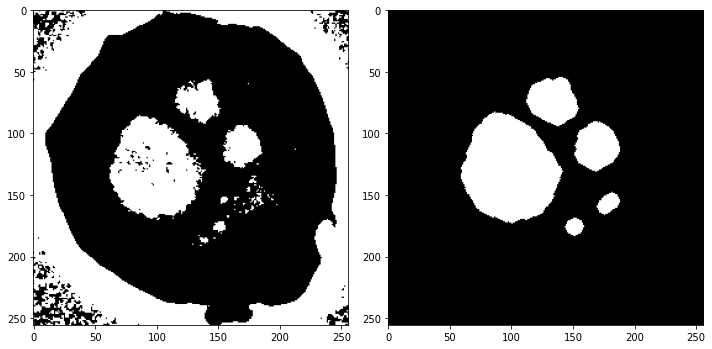

In [152]:
# dice loss / F1 
def dsc(pred, target):
    intersection = np.sum((pred * target))
    loss = (2. * intersection) / (np.sum(pred) + np.sum(target))
    return loss

print("Local threshold F1:", dsc(denoise, tmp_labels2))

idx = 2
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,5))
axs[0].imshow(bins[idx], cmap="gray")
axs[1].imshow(denoise[idx], cmap="gray")

In [153]:
def clean_labels(labels): 
    cc = labels.copy()
    props = [measure.regionprops(img) for img in cc]
    for idx_img, img in enumerate(props):
        idx = 0
        for region in img:
            idx += 1
            x, y = region.centroid[0].astype(int), region.centroid[1].astype(int)
            if cc[idx_img][x, y] != idx or region.extent < 0.4:
                cc[idx_img][cc[idx_img] == idx] = 0
    return cc

def evaluate_img(gtimg, img): 
    temp_img = np.zeros((img.shape[0],img.shape[1],))
    
    for i in range(img.shape[0]): 
        for j in range(img.shape[1]):
            if gtimg[i, j] == 1 and 0 != img[i, j]:
                temp_img[i,j] = 1
            elif gtimg[i, j] == 1 and 0 == img[i, j]:
                temp_img[i,j] = 2
            elif gtimg[i, j] == 0 and 0 != img[i, j]:
                temp_img[i,j] = 3
            elif gtimg[i, j] == 0 and 0 == img[i, j]:
                temp_img[i,j] = 0
                
    return temp_img

In [154]:
# denoise and make inference 
def sdm_predict(new_data, tmp_masks, thr_val):
    preds_ori = new_data>thr_val #0.027
    preds = preds_ori.copy()
    
    cann = np.array([feature.canny(im, sigma=1.3, low_threshold=0.4/255., high_threshold=150/255.) for im in tmp_masks])
    cann =  np.array([skmorph.binary_dilation(im, skmorph.disk(3)) for im in cann])
    preds = np.array([skmorph.binary_opening(im, skmorph.disk(4)) for im in preds])
    preds = np.array([skmorph.binary_opening(im, skmorph.disk(4)) for im in preds])
    preds[cann==1] = 1

    cc = np.array([skmorph.label(img.astype(np.uint8), connectivity=1) for img in preds])
    res = clean_labels(cc) != 0
    selem = skmorph.disk(5)
    res = np.array([skmorph.remove_small_objects(im, min_size=5) for im in res])
    res = np.array([skmorph.binary_closing(im, selem) for im in res])
    res = np.array([skmorph.binary_closing(im, selem) for im in res])
    res_dilated = np.array([skmorph.binary_closing(im, selem) for im in res])
    res_dilated =  np.array([skmorph.binary_dilation(im, selem) for im in res_dilated])

    return res_dilated

In [155]:
from scipy.ndimage import morphology
from scipy.optimize import curve_fit

# general function to fit radiograph intensity vs distance to particle edge
def func(x,a,b,c):
    return a*np.exp(-b*x) +c
#     return a*np.exp(-b*np.sqrt(d*x-x**2))+c #more accurate but not feasible 

## attenuation-adjusted threshold model 
def att_adj_thr(f, tmp_masks, tmp_data, tmp_labels=None, iter=1, thr_val=0.027): 
    new_data = tmp_data
    pore_preds = np.zeros_like(tmp_masks)
    thr = np.round(tmp_masks)

    for i in range(1, iter+1):
        binary_labels = 1 - np.round(pore_preds)
        box = np.zeros_like(thr)
        box[:,1:-1, 1:-1] = 1
        
        dist = np.array([morphology.distance_transform_edt(im) for im in thr])

        dist_original = dist.copy()
        dist *= binary_labels
        
        bins = np.array([np.linspace(1, np.max(d[d>0]), 95) for d in dist]) #qlk: 95
        digitized = np.array([np.digitize(d[d>0], b) for d, b in zip(dist, bins)])
        
        bin_means = np.array([[np.percentile(im[dist[j]>0][digitized[j] == i], 40) for i in range(1, len(bins[j]))] for j, im in enumerate(tmp_data)])
        vars = [curve_fit(f, b, m, maxfev=1000)[0].tolist() for b, m in zip(bins[:,:-1], bin_means)]
        
        # subtract sdm
        ints = np.array([func(d, *vars[i]) for i, d in enumerate(dist_original)])
        ints[thr==0] = tmp_data[thr==0]

        new_data = tmp_data - ints 
        new_data = np.nan_to_num(new_data, nan=1)
        
        # make predictions (not necessary for last iteration of "Combined" model)
        pore_preds = sdm_predict(new_data, tmp_masks, thr_val)
        
    return new_data, pore_preds, vars, dist_original

new_data, pore_preds, vars, dist_maps = att_adj_thr(func, tmp_masks, tmp_data, tmp_labels, iter=6)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  


In [156]:
from sklearn.utils import shuffle

# prepare data for PyTorch fun 
data = np.append(new_data, np.flip(new_data, 1), axis=0)   #data for Combined model  
# data = np.append(tmp_data, np.flip(tmp_data, 1), axis=0) #data for UNet model
data = np.append(data, np.flip(data, 2), axis=0) 
data_y = np.append(tmp_labels, np.flip(tmp_labels, 1), axis=0) 
data_y = np.append(data_y, np.flip(data_y, 2), axis=0) 
data, data_y = shuffle(data, data_y)


# splice
DATA_N = 24
VAL_N = 4
TEST_N = len(data_test)

data_train = data[:DATA_N]
labels_train = data_y[:DATA_N]
data_val = data[DATA_N:DATA_N+VAL_N]
labels_val = data_y[DATA_N:DATA_N+VAL_N]
print("Train and validation shapes:\n", data_train.shape,data_val.shape)

Train and validation shapes:
 (24, 256, 256) (4, 256, 256)


In [17]:
import torch
import torch.nn as nn

device = torch.device('cuda')

# double conv block
def conv2x(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.Conv2d(in_channels, out_channels,3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = conv2x(1, 64)
        self.down2 = conv2x(64, 128)
        self.down3 = conv2x(128, 256)
        self.down4 = conv2x(256, 512)
        self.down5 = conv2x(512, 1024)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.up4 = conv2x(512 + 1024, 512)
        self.up3 = conv2x(256 + 512, 256)
        self.up2 = conv2x(128 + 256, 128)
        self.up1 = conv2x(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.maxpool(x1))
        x3 = self.down3(self.maxpool(x2))
        x4 = self.down4(self.maxpool(x3))
        x = self.down5(self.maxpool(x4))

        x = self.up4(torch.cat([self.upsample(x),x4], dim=1))
        x = self.up3(torch.cat([self.upsample(x),x3], dim=1))
        x = self.up2(torch.cat([self.upsample(x),x2], dim=1))
        x = self.up1(torch.cat([self.upsample(x),x1], dim=1))

        return self.conv_last(x)

model = UNet().cuda()

In [18]:
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)

# load pretrained model 
PATH = "../input/pretrained-model/pretrained_model_sdf"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
history = checkpoint['history'][0].tolist()
train_history  = checkpoint['history'][1].tolist()
val_history = checkpoint['history'][2].tolist()

In [157]:
RES = (256,256)
d_shape = (DATA_N,1,*RES)
val_shape = (VAL_N,1,*RES)

data_train = torch.from_numpy(data_train).float().reshape(d_shape)
data_train.requires_grad = True
labels_train = torch.from_numpy(labels_train).float().reshape(d_shape)

data_val = torch.from_numpy(data_val).float().reshape(val_shape)
labels_val = torch.from_numpy(labels_val).float().reshape(val_shape)


In [20]:
def training_loop(n_epochs, batch_size, optimizer, model, loss_fn, data_train,
                  labels_train, data_val, labels_val):
    tmp = torch.stack((data_train, labels_train))
    data_val = data_val.cuda()
    labels_val = labels_val.cuda()

    for epoch in range(1, n_epochs + 1):
        with torch.no_grad():
            idx = torch.randperm(labels_train.shape[0]) #shuffle
            data_train, labels_train = tmp[:,idx].view(tmp.size())
            data_train = data_train.cuda()
            labels_train = labels_train.cuda()
        for mb in range(int(len(data_train)/batch_size)):
            preds = model(data_train[mb*batch_size:(mb+1)*batch_size])
            loss_train = loss_fn(preds, labels_train[mb*batch_size:(mb+1)*batch_size])
        
            preds_val = model(data_val) 
            loss_val = loss_fn(preds_val, labels_val)

            optimizer.zero_grad()
            loss_train.backward()

            optimizer.step()
            history.append((epoch-1)*int(len(data_train)/batch_size) + mb)
            train_history.append(float(loss_train))
            val_history.append(float(loss_val))

            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                    epoch, float(loss_train), float(loss_val)))


In [21]:
n_epochs = 22 #25
batch_size = 8
label_ratio = torch.tensor(np.count_nonzero(data_y==0)/np.sum(data_y))  #21.9

optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)

model.train()
start_time = time.time()

training_loop(
    n_epochs = n_epochs, 
    batch_size = batch_size,
    optimizer = optimizer,
    model = model,
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5)), #label_ratio),
    data_train = data_train,
    labels_train = labels_train,
    data_val = data_val, 
    labels_val = labels_val
    )
print("--- %s seconds ---" % (time.time() - start_time))
model.eval()

Epoch 1, Training loss 0.5913040637969971, Validation loss 0.6353614330291748
Epoch 1, Training loss 0.823290228843689, Validation loss 0.6487436890602112
Epoch 1, Training loss 0.5689226388931274, Validation loss 0.44104552268981934
Epoch 2, Training loss 1.3289740085601807, Validation loss 1.4156856536865234
Epoch 2, Training loss 0.5738192796707153, Validation loss 0.41122812032699585
Epoch 2, Training loss 0.43488436937332153, Validation loss 0.42205482721328735
Epoch 3, Training loss 0.5492745041847229, Validation loss 0.4247923195362091
Epoch 3, Training loss 0.4439268708229065, Validation loss 0.41548725962638855
Epoch 3, Training loss 0.3471294045448303, Validation loss 0.40129876136779785
Epoch 4, Training loss 0.392336905002594, Validation loss 0.39281216263771057
Epoch 4, Training loss 0.4111315608024597, Validation loss 0.3868881165981293
Epoch 4, Training loss 0.407261461019516, Validation loss 0.376346230506897
Epoch 5, Training loss 0.3961006999015808, Validation loss 0.

UNet(
  (down1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (down3): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (down4): Sequential(

In [158]:
from scipy.optimize import minimize

## find best threshold w.r.t. F1 on validation set; otherwise 0.5 for best loss 

def obj(thr, X, Y):
    return -dsc(X>thr, Y)

val_preds = torch.sigmoid(model(data_val.cuda()))

init_thr = 0.5
min_result = minimize(obj, init_thr, args=(val_preds.detach().cpu().numpy().flatten(),
                                           labels_val.detach().cpu().numpy().flatten()),
                                     options={'maxiter': 500}, method="Powell")
best_thr = min_result["x"]
min_result

   direc: array([[1.]])
     fun: -0.8926829268292683
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 2
  status: 0
 success: True
       x: array([0.737969])

In [159]:
# prepare test data 
clean2, props2 = cutout_pre(data_test)
tmp_data2, tmp_labels2, tmp_masks2 = cutout(data_test, labels_test, clean2, props2)
res, pore_preds, vars, dist_maps2 = att_adj_thr(func, tmp_masks2, tmp_data2, tmp_labels2, iter=4) 

test_shape = (len(tmp_data2),1,*RES)
res = torch.from_numpy(res).float().reshape(test_shape).cuda()
tmp_labels2 = torch.from_numpy(tmp_labels2).float().reshape(test_shape)

preds = torch.sigmoid(model(res)) 
preds = preds.detach().cpu().squeeze(1).numpy()

#prepare for plotting
tmp_labels2 = tmp_labels2.squeeze(1).numpy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  


Combined:  0.8570484515334474
Local threshold:  0.8257487706750112
Attenuation-adjusted:  0.7651489001161076


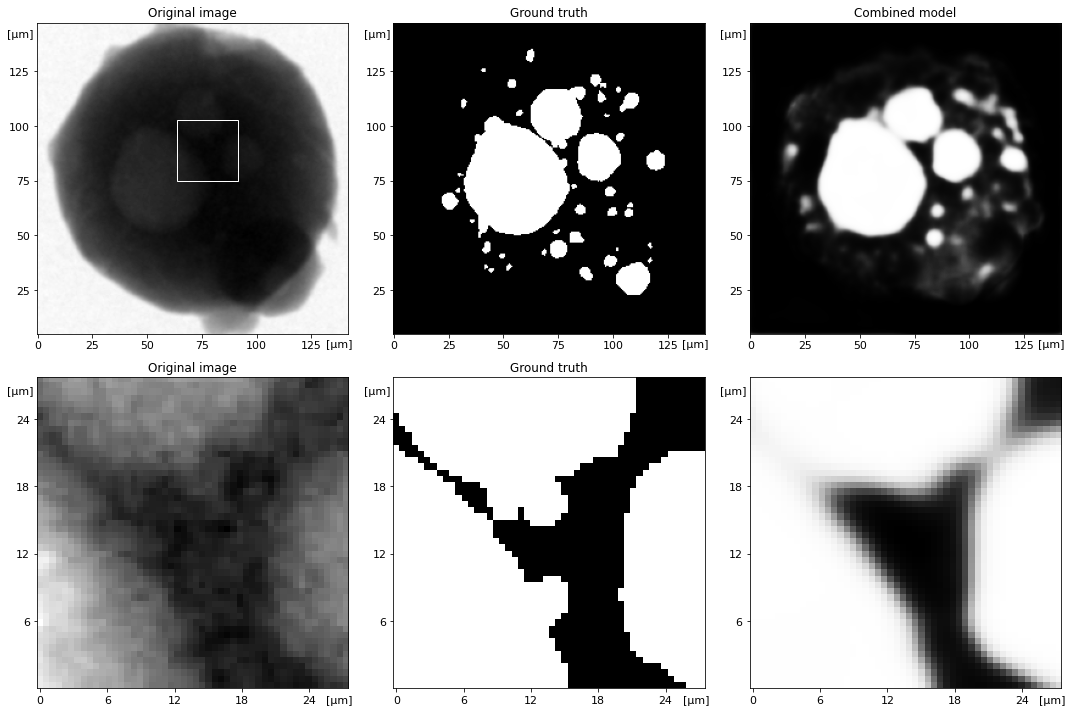

In [160]:
import matplotlib.patches as patches

fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(15,10))

SCALE = 209/256
def do_axes1():
    xts = np.arange(0, 256*0.68*scale, 25)
    xt = xts / 0.68 / scale
    xts = [str(elem)[:-2] for elem in xts]
    plt.xticks(xt, xts, fontsize=11)
    plt.yticks(np.flip(xt)+39.5, xts, fontsize=11)
    plt.text(474/2, 533/2, "[μm]", fontsize=11)
    plt.text(-25, 12, "[μm]", fontsize=11)
    
def do_axes2():
    xts = np.arange(0, 50*0.68*scale, 6)
    xt = xts / 0.68 / scale
    xts = [str(elem)[:-2] for elem in xts]
    plt.xticks(xt, xts, fontsize=11)
    plt.yticks(np.flip(xt)+6.275, xts, fontsize=11)
    plt.text(46, 52, "[μm]", fontsize=11)
    plt.text(-5.27, 2.34, "[μm]", fontsize=11)

for i in [0,1]:
    for j in [0,1,2]:
        plt.sca(axs[i,j])
        do_axes1() if i == 0 else do_axes2() 



idx=2
axs[0, 0].imshow(data_before[idx], cmap="gray")
rect = patches.Rectangle((115,80), 50, 50, linewidth=1, edgecolor='w', facecolor='none')
axs[0, 0].add_patch(rect)

axs[0, 1].imshow(tmp_labels2[idx], cmap="gray")
axs[0, 2].imshow((preds)[idx], cmap="gray")
axs[1, 0].imshow(data_before[idx][80:130, 115:165], cmap="gray") #.squeeze().cpu().numpy()
axs[1, 1].imshow(tmp_labels2[idx][80:130, 115:165], cmap="gray")
axs[1, 2].imshow(preds[idx][80:130, 115:165], cmap="gray")
axs[0,0].set_title("Original image", fontdict={"fontsize":12})
axs[0,1].set_title("Ground truth", fontdict={"fontsize":12})
axs[0,2].set_title("Combined model", fontdict={"fontsize":12})
axs[1,0].set_title("Original image", fontdict={"fontsize":12})
axs[1,1].set_title("Ground truth", fontdict={"fontsize":12})
axs[1,2].set_title("Combined model", fontdict={"fontsize":12})
plt.title("")
# plt.savefig("pretrained_segmentation.pdf")

print("Combined: ", dsc(np.round(preds>best_thr), tmp_labels2))
print("Local threshold: ", dsc(np.round(pore_preds), tmp_labels2))
print("Attenuation-adjusted: ", dsc(np.round(denoise), tmp_labels2))


In [161]:
from sklearn import metrics

np_labels = np.round(tmp_labels2).flatten()

cm_cutout = metrics.confusion_matrix(np_labels, np.round(preds>best_thr).flatten(), normalize='true')
cm_cutout2 = metrics.confusion_matrix(np_labels, np.round(preds>best_thr).flatten())

cm_cutout, cm_cutout2, dsc(np.round(preds>best_thr).flatten(), np_labels)

(array([[0.98347042, 0.01652958],
        [0.16840571, 0.83159429]]),
 array([[224068,   3766],
        [  5778,  28532]]),
 0.8570484515334474)

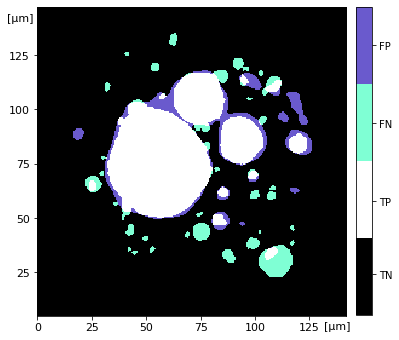

In [162]:
from matplotlib import colors

idx=2
gg = evaluate_img(tmp_labels2[idx], preds[idx]>0.5) #or >best_thr

fig, ax = plt.subplots(figsize=(6,6))
do_axes1()
cmap = colors.ListedColormap(['k', 'white', "aquamarine", "slateblue"])
cax = ax.imshow(gg, cmap=cmap, interpolation='nearest')
cbar = fig.colorbar(cax, ticks=[0.4,1.11,1.87,2.63], fraction=0.04602, pad=0.0302)
cbar.ax.set_yticklabels(["TN", "TP", "FN", "FP"]);  # vertically oriented colorbar
# plt.savefig("err_local.pdf")

In [163]:
preds_ = np.load("../input/preds-034-model-thr-0814/preds_031_unet_thr_0.824.npy")
preds2_ = np.load("../input/preds-034-model-thr-0814/preds_034_val_model_thr_0814.npy")

preds_labels = [measure.label(im) for im in np.round(preds2_>0.5)]
preds_labels2 = [measure.label(im) for im in np.round(preds_>0.5)]
preds_labels_thr= [measure.label(im) for im in np.round(pore_preds)]
preds_labels_loc= [measure.label(im) for im in denoise]
true_labels = [measure.label(im) for im in tmp_labels2]

preds_props = [measure.regionprops(im) for im in preds_labels]
preds_props2 = [measure.regionprops(im) for im in preds_labels2]
preds_props_thr = [measure.regionprops(im) for im in preds_labels_thr]
preds_props_loc = [measure.regionprops(im) for im in preds_labels_loc]
true_props = [measure.regionprops(im) for im in true_labels]

preds_dist = []
preds_dist2 = []
preds_dist_thr = []
preds_dist_loc = []
true_dist = []

for i in range(len(preds_props)): 
    for j in range(max(len(preds_props[i]), len(true_props[i]))):
        if j < len(preds_props[i]):
            preds_dist.append(preds_props[i][j].area)
        if j < len(true_props[i]):
            true_dist.append(true_props[i][j].area)
            
for i in range(len(preds_props2)): 
    for j in range(max(len(preds_props2[i]), len(true_props[i]))):
        if j < len(preds_props2[i]):
            preds_dist2.append(preds_props2[i][j].area)
            
for i in range(len(preds_props_thr)): 
    for j in range(max(len(preds_props_thr[i]), len(true_props[i]))):
        if j < len(preds_props_thr[i]):
            preds_dist_thr.append(preds_props_thr[i][j].area)

for i in range(len(preds_props_loc)): 
    for j in range(max(len(preds_props_loc[i]), len(true_props[i]))):
        if j < len(preds_props_loc[i]):
            preds_dist_loc.append(preds_props_loc[i][j].area)

preds_dist = np.array(preds_dist)
preds_dist2 = np.array(preds_dist2)
preds_dist_thr = np.array(preds_dist_thr)
preds_dist_loc = np.array(preds_dist_loc)
true_dist = np.array(true_dist)

(1.1283791670955126,
 5.781222885281108,
 8.83096382707056,
 0.7978845608028654,
 0.5641895835477563)

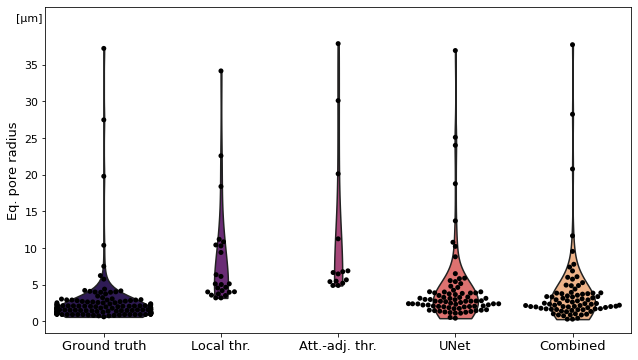

In [164]:
import pandas as pd
import seaborn as sns


np_data = np.array([np.sqrt(true_dist/np.pi).T, np.sqrt(preds_dist_loc/np.pi).T,
                    np.sqrt(preds_dist_thr/np.pi).T,np.sqrt(preds_dist2/np.pi).T,
                    np.sqrt(preds_dist/np.pi).T],dtype=object)


df = pd.DataFrame(data=np_data, index=["Ground truth", "Local threshold", 
                                       "Attenuation-adjusted threshold", "UNet",
                                       "Combined"], columns=["area"])

plt.figure(figsize=(10.5,6))
sns.violinplot(data=df["area"], palette="magma", cut=0, scale="count", size=20, inner=None)
ax = sns.swarmplot(data=df["area"], color="black")#, s=3)#, color="black")

plt.ylabel("Eq. pore radius", fontsize=13)
plt.xticks([0, 1, 2, 3, 4], ["Ground truth", "Local thr.", "Att.-adj. thr.", "UNet", "Combined"], fontsize=13)

xts = np.arange(0, 70*0.68*scale, 5)
xt = xts / 0.68 / scale
xts = [str(elem)[:-2] for elem in xts]
plt.yticks(xt, xts, fontsize=11)
plt.ylim((-2.7906, 77.3))
plt.text(-0.75, 73.61, "[μm]", fontsize=11)
np_data[0].min(), np_data[1].min(), np_data[2].min(), np_data[3].min(), np_data[4].min()
# plt.savefig("violin_combined.pdf")


In [ ]:
# ... and further plotting 